In [ ]:
import numpy as np
import spotpy
import pickle
import pandas as pd
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.hymod import LinearReservoir
from superflexpy.implementation.elements.gr4j import ProductionStore
from superflexpy.implementation.elements.structure_elements import  Splitter, Junction
from superflexpy.framework.unit import Unit
from superflexpy.framework.element import ParameterizedElement

from datetime import datetime, timedelta
train_start = '01/10/2006'
train_end   = '30/09/2008'
basin = "01350080"

def load_data(basin,train_start,train_end):
    p = load_p(basin,train_start,train_end)
    pet = load_pet(basin,train_start,train_end)
    data = np.vstack((p,pet)).T
    return data
def load_p(basin,train_start,train_end):
    train_start_dt = datetime.strptime(train_start, '%d/%m/%Y')
    train_end = datetime.strptime(train_end, '%d/%m/%Y')
    len_seq = (train_end - train_start_dt).days
    f = open("data/CAMELS_US/basin_mean_forcing/daymet/02/"+basin+"_lump_cida_forcing_leap.txt")
    f.readline()
    f.readline()
    f.readline()
    f.readline()
    l = f.readline().split('\t')
    x = np.zeros(len_seq)
    train_start = train_start.split('/')
    train_start.reverse()
    train_start = ' '.join(train_start)
    while l[0] != train_start+' 12':
        l = f.readline().split('\t')
    for i in range(len_seq):
        x[i] = float(l[2])
        l = f.readline().split('\t')
    return x

def load_pet(basin,train_start,train_end):
    with open("data\pet.pkl", "rb") as fp:
        results = pickle.load(fp)
        results = results[basin]
        results.index = pd.to_datetime(results.index)
        train_start = datetime.strptime(train_start, '%d/%m/%Y')
        train_end = datetime.strptime(train_end, '%d/%m/%Y') - timedelta(days=1)
        results = results.loc[train_start:train_end]
        results = results['PET(mm/d)'].values
        results = np.maximum(0.0,results)
    return results

# 1 - Datasets

In [ ]:
def get_area(basin):
    with open("data/CAMELS_US/basin_mean_forcing/daymet/02/"+basin+"_lump_cida_forcing_leap.txt", 'r') as fp:
        # load area from header
        fp.readline()
        fp.readline()
        area = int(fp.readline())
    return area

def load_qobs(basin,train_start,train_end):
    area = get_area(basin)
    train_start_dt = datetime.strptime(train_start, '%d/%m/%Y')
    train_end = datetime.strptime(train_end, '%d/%m/%Y')
    len_seq = (train_end - train_start_dt).days
    x = np.zeros(len_seq)
    train_start = train_start.split('/')
    train_start.reverse()
    train_start = ' '.join(train_start)
    f = open("data/CAMELS_US/usgs_streamflow/02/"+basin+"_streamflow_qc.txt")
    l = f.readline()[9:].split(" ")
    while ' '.join([l[i] for i in range(3)]) != train_start:
        l = f.readline()[9:].split(' ')
    for i in range(len_seq):
        x[i] = float(l[-2])
        l = f.readline()[9:].split(' ')
    x = 28316846.592 * x * 86400 / (area * 10**6)
    return x
    
P    = load_p(basin, train_start, train_end)
Ep   = load_pet(basin, train_start, train_end)
Qobs = load_qobs(basin, train_start, train_end)

# 2 - Superflex model creation

In [ ]:
class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'split-par']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    

def create_superflex_model():
    # Initialize numercal routines
    root_finder = PegasusPython()
    numeric_approximator = ImplicitEulerPython(root_finder=root_finder)

    # Initialize the elements
    lr_1 = LinearReservoir(
        parameters={'k': 0.5},
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='LR-1'
    )

    lr_2 = LinearReservoir(
        parameters={'k': 4.0},
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='LR-2'
    )

    tr = ProductionStore(
        parameters={'x1': 20.0, 'alpha': 2.0,
                    'beta': 2.0, 'ni': 0.0},
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='TR'
    )
    splitter = ParameterizedSingleFluxSplitter(
                        parameters={'split-par': 0.9},
                        id='spl'
    )

    junction = Junction(direction=[[0, 0]], # Third output
                        id='jun')

    model = Unit(layers=[[tr],
                        [splitter],
                        [lr_1, lr_2],
                        [junction]],
                id='model')
    return model

sf_model = create_superflex_model()

# 3 - Metric

In [ ]:
def obj_fun_nsee(observations, simulation, expo = 0.5):
    metric = np.nansum(np.power(np.power(simulation, expo)  - np.power(observations,expo), 2)) / np.nansum(np.power(np.power(observations, expo)  - np.nanmean(np.power(observations, expo)), 2))
    return float(metric)

# 4 - Spotpy model

In [ ]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        
        return obj_fun

In [ ]:
spotpy_sf = spotpy_model(
    model=sf_model,
    inputs=[Ep,P],
    dt=1.0,
    observations = Qobs,
    parameters=[
        spotpy.parameter.Uniform('model_TR_x1', 1.0, 50.0),
        spotpy.parameter.Uniform('model_LR-1_k', 0.01, 50.0),
        spotpy.parameter.Uniform('model_LR-2_k', 0.01, 50.0),
        spotpy.parameter.Uniform('model_spl_split-par', 0.0, 1.0)
    ],
    parameter_names=['model_TR_x1','model_LR-1_k','model_LR-2_k','model_spl_split-par'],
    output_index=0,
    warm_up=0
)

# 5 - Calibration

In [ ]:
sampler = spotpy.algorithms.sceua(spotpy_sf, dbname='calibration', dbformat='csv')
sampler.sample(repetitions=500)

# 6 - Running NH

In [1]:
from neuralhydrology.nh_run import start_run
from pathlib import Path
start_run(config_file=Path("examples/07-Superflex/example4.yml", gpu=-1))


2024-03-28 17:32:09,949: Logging to runs\run_2803_173209\output.log initialized.
2024-03-28 17:32:09,949: ### Folder structure created at runs\run_2803_173209
2024-03-28 17:32:09,949: ### Run configurations for run
2024-03-28 17:32:09,949: experiment_name: None
2024-03-28 17:32:09,949: run_dir: runs\run_2803_173209
2024-03-28 17:32:09,949: train_basin_file: examples\07-Superflex\6_basins_list.txt
2024-03-28 17:32:09,949: validation_basin_file: examples\07-Superflex\6_basins_list.txt
2024-03-28 17:32:09,949: test_basin_file: examples\07-Superflex\6_basins_list.txt
2024-03-28 17:32:09,949: train_start_date: 2006-10-01 00:00:00
2024-03-28 17:32:09,949: train_end_date: 2008-09-30 00:00:00
2024-03-28 17:32:09,949: validation_start_date: 2002-10-01 00:00:00
2024-03-28 17:32:09,966: validation_end_date: 2004-09-30 00:00:00
2024-03-28 17:32:09,966: test_start_date: 1998-10-01 00:00:00
2024-03-28 17:32:09,966: test_end_date: 2000-09-30 00:00:00
2024-03-28 17:32:09,969: per_basin_train_periods_

# 7 - Results

## 7.1 - Neuralhydrology outflow analysis

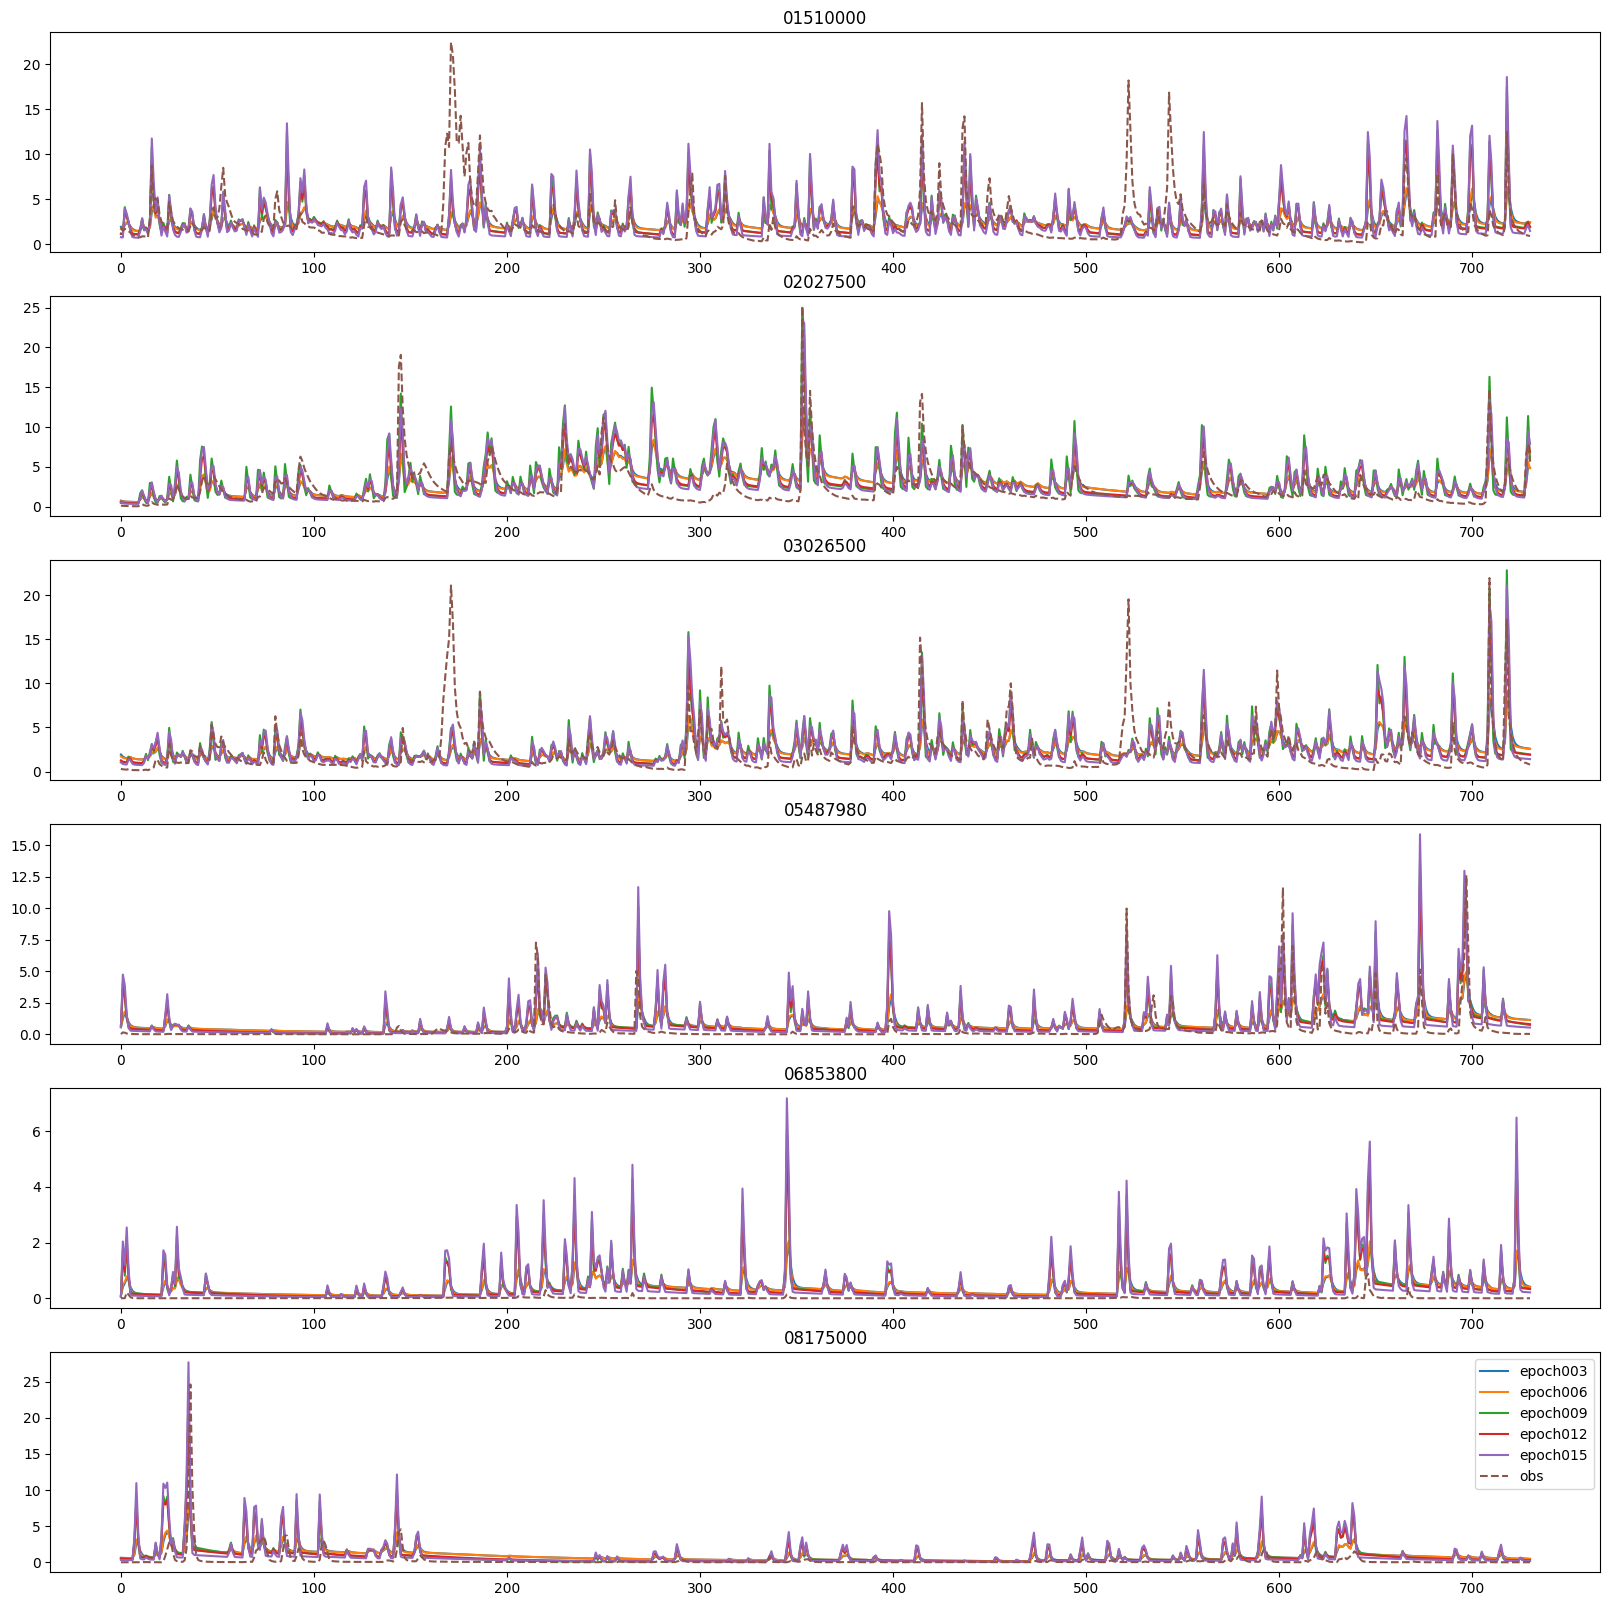

In [2]:
#===========SET THIS=================
run_dir = "runs/run_2803_173209"
epoch_max = 15
validation_interval = 3
basins = ["01510000",
          "02027500",
          "03026500",
          "05487980",
          "06853800",
          "08175000"]
#basins = ["01333000",'01333000']
#------------------------------------

def epoch_int_to_str(nb_epochs):
    nb_epochs = str(nb_epochs)
    nb_epochs = (3-len(nb_epochs))*'0'+nb_epochs
    return nb_epochs


basins = basins
import pickle
import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(basins), figsize=(20, 20))
for ib, basin in enumerate(basins):
    for nb_epochs in range(validation_interval,epoch_max+1,validation_interval):
        nb_epochs = epoch_int_to_str(nb_epochs)
        with open(run_dir + "/validation/model_epoch"+nb_epochs+"/validation_results.p", "rb") as fp:
            results = pickle.load(fp)
            qsim = results[basin]['1D']['xr']['QObs(mm/d)_sim'].squeeze().values
            qobs = results[basin]['1D']['xr']['QObs(mm/d)_obs']
            ax[ib].plot(qsim,label='epoch'+nb_epochs)
    ax[ib].plot(qobs.squeeze().values,'--',label='obs')
    ax[ib].set_title(basin)
plt.legend()
plt.show()

## 7.2 - Neuralhydrology parameters analysis

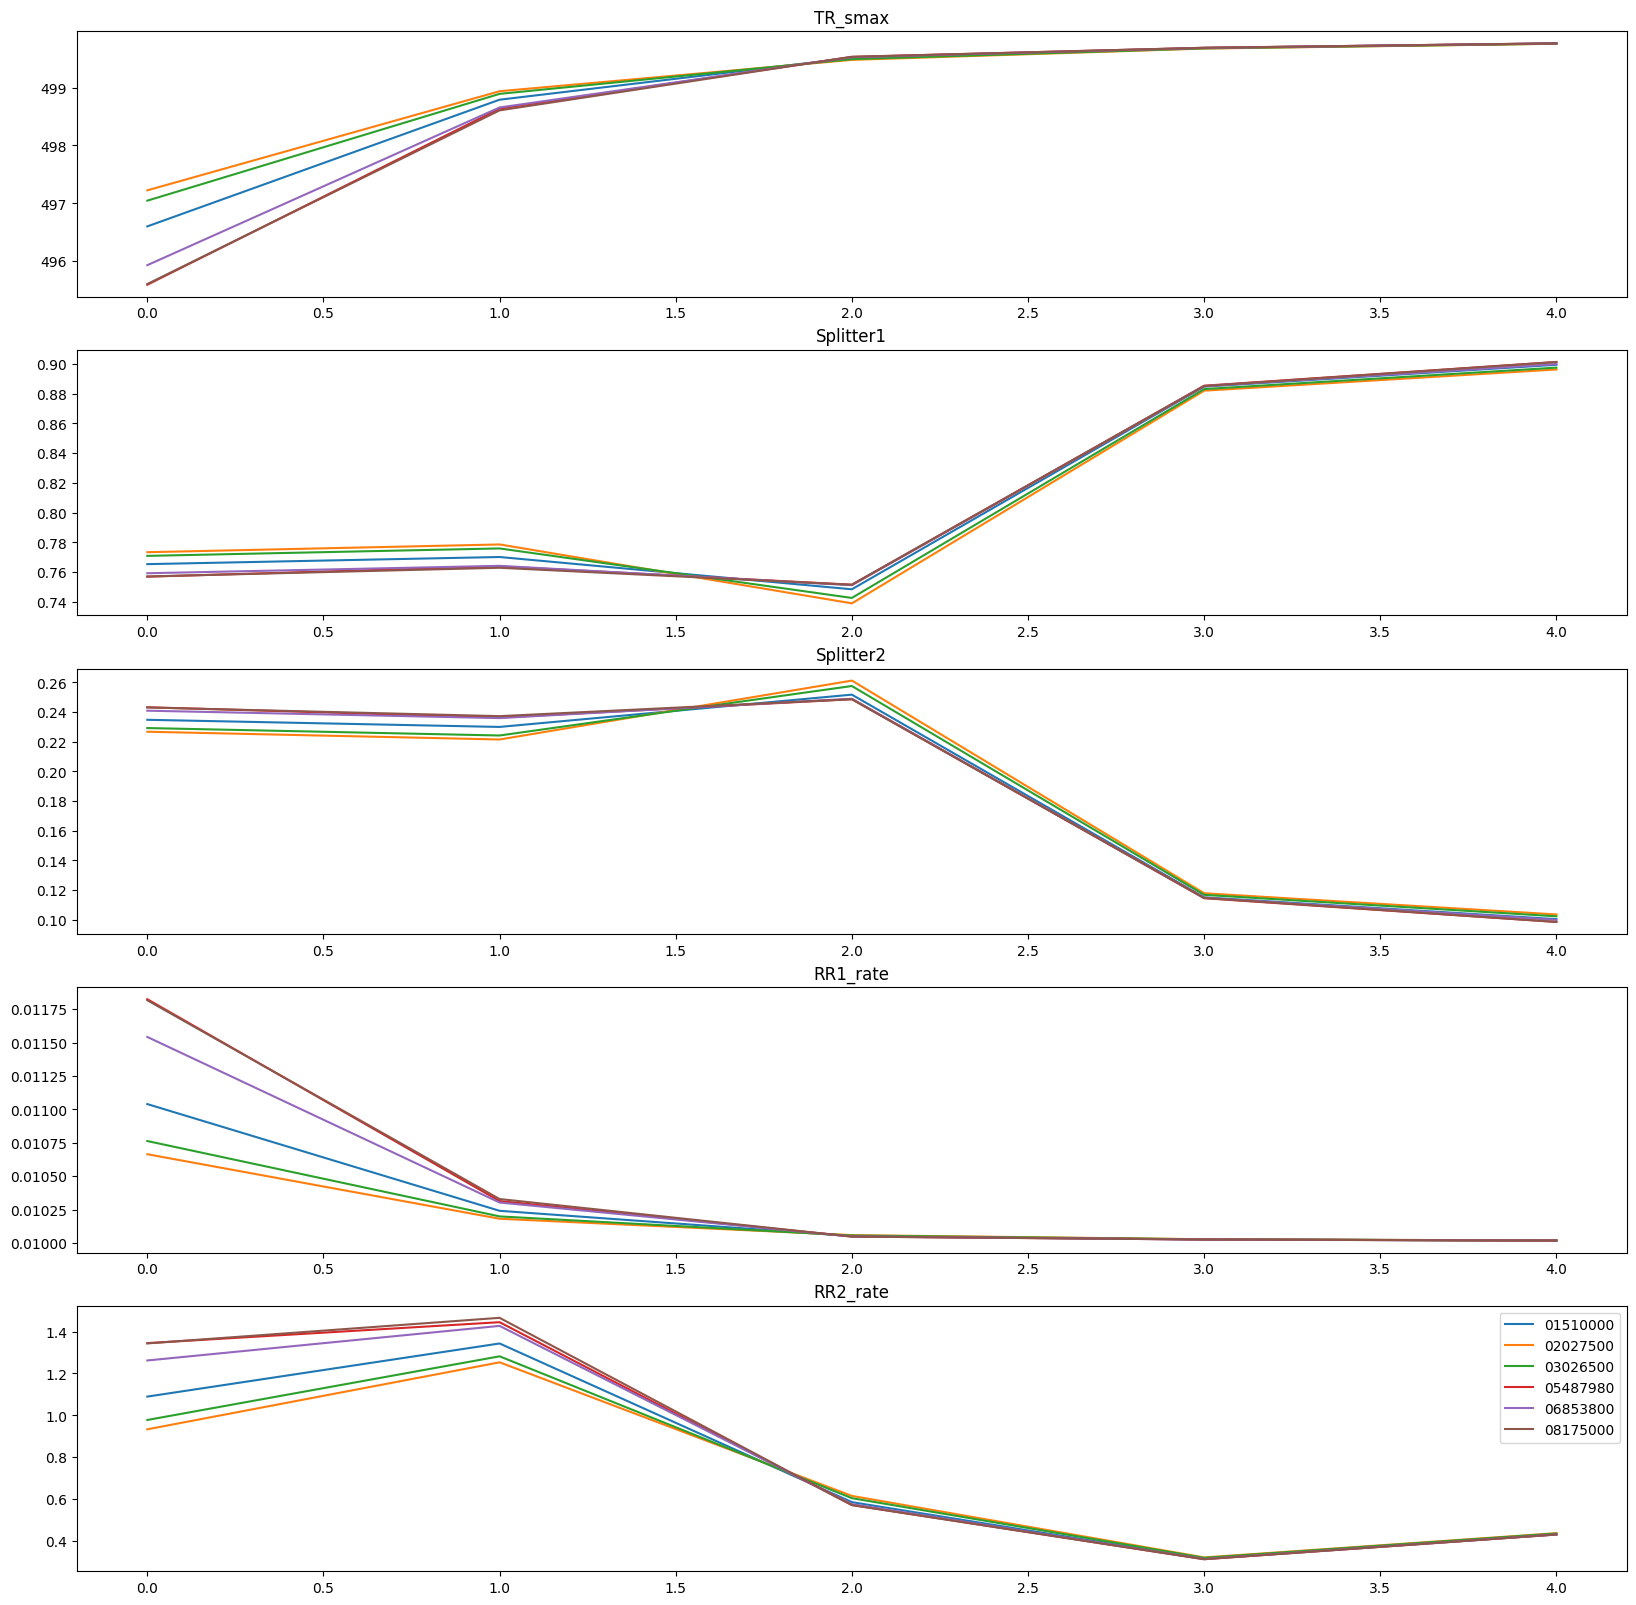

In [5]:
from torch import load,nn, tensor, float32
from neuralhydrology.datasetzoo.camelsus import load_camels_us_attributes
#===========SET THIS=================
#run_dir = "runs/run_2203_133730"
#epoch_max = 10
#validation_interval = 2
#basins = ["01510000",
#          "02027500",
#          "03026500",
#          "05487980",
#          "06853800",
#          "08175000"]
#------------------------------------

def scale_output(x, min_val, max_val):
    scaled_x = x * (max_val - min_val) + min_val
    return scaled_x.detach().item()


class MyModel(nn.Module):
    def __init__(self):
        #torch.nn.Sequential(torch.nn.Linear(in_features=static_inputs_size, out_features=20),
        #                    torch.nn.Sigmoid(), torch.nn.Dropout(p=0.0),
        #                    torch.nn.Linear(in_features=20, out_features=total_parameters),
        #                    torch.nn.Sigmoid())
        super(MyModel, self).__init__()
        self.parameterization = nn.Sequential(nn.Linear(in_features=3, out_features=20),
                                                    nn.Sigmoid(), nn.Dropout(p=0.0),
                                                    nn.Linear(in_features=20, out_features=20),
                                                    nn.Sigmoid(),
                                                    nn.Linear(in_features=20, out_features=5),
                                                    nn.Sigmoid())

    def forward(self, x):
        return self.parameterization(x)

def get_parameters_values(run_dir,epoch_str,basin):
    ordereddict = load(run_dir+'/model_epoch'+epoch_str+'.pt')
    m = MyModel()
    m.load_state_dict(ordereddict)
    x_s = load_camels_us_attributes("data/CAMELS_US",basins)
    x_s = tensor(x_s.loc[basin,["baseflow_index", "high_q_freq", "aridity"]].values.astype(float),dtype=float32)
    return m(x_s)

parameter_names = ["TR_smax","Splitter1","Splitter2","RR1_rate","RR2_rate"]
parameters = [[[] for j in basins] for i in parameter_names]
for ib, basin in enumerate(basins):
    for nb_epochs in range(validation_interval,epoch_max+1,validation_interval):
        nb_epochs = epoch_int_to_str(nb_epochs)
        params_epoch = get_parameters_values(run_dir, nb_epochs, basin)
        parameters[0][ib].append(scale_output(params_epoch[0], 1.0, 500.0))
        weights = params_epoch[1:3]
        row_sums = weights.sum()
        normalized_weights = weights / row_sums
        parameters[1][ib].append(normalized_weights[0].detach().item())
        parameters[2][ib].append(normalized_weights[1].detach().item())
        parameters[3][ib].append(scale_output(params_epoch[3], 0.01, 50.0))
        parameters[4][ib].append(scale_output(params_epoch[4], 0.01, 50.0))
        #parameters[1][ib].append(scale_output(params_epoch[1], 0.01, 50.0))

fig, ax = plt.subplots(len(parameter_names), figsize=(20, 20))
for ip, param in enumerate(parameter_names):
    for ib, basin in enumerate(basins):
        ax[ip].plot(parameters[ip][ib],label=basin)
    ax[ip].set_title(param)
plt.legend()
plt.show()

## 7.3 - Comparison with Superflex

In [ ]:
from neuralhydrology.evaluation import metrics
basin = "01350080"
nb_epochs = 15
root_finder = PegasusPython()
numeric_approximator = ImplicitEulerPython(root_finder=root_finder)
lr_1 = LinearReservoir(
    parameters={'k': 19.8616},#0.0336838
    states={'S0': 0.0},
    approximation=numeric_approximator,
    id='LR-1'
)
lr_2 = LinearReservoir(
    parameters={'k': 0.136237},#18.2155
    states={'S0': 0.0},
    approximation=numeric_approximator,
    id='LR-2'
)
tr = ProductionStore(
    parameters={'x1': 30.2143, 'alpha': 2.0, #34.9774
                'beta': 2.0, 'ni': 0.0},
    states={'S0': 0.0},
    approximation=numeric_approximator,
    id='TR'
)
splitter = Splitter(weight=[[0.0756081], [1-0.0756081]], #0.635073
                direction=[[0], [0]],
                id='spl')

junction = Junction(direction=[[0, 0]], # Third output
                    id='jun')

model_sf = Unit(layers=[[tr],
                    [splitter],
                    [lr_1, lr_2],
                    [junction]],
            id='model')

P = load_p(basin, '01/10/2002','30/09/2004')
Ep = load_pet(basin, '01/10/2002','30/09/2004')

model_sf.reset_states()
model_sf.set_input([Ep,P])
model_sf.set_timestep(1.0)
output_sf = model_sf.get_output()[0]



from math import sqrt

def mean(l):
    return sum(l)/len(l)

def stdev(l):
    m = mean(l)
    return sqrt(sum([(i-m)**2 for i in l])/len(l))

import seaborn as sns
import pickle
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(20, 10))
nb_epochs = str(nb_epochs)
nb_epochs = (3-len(nb_epochs))*'0'+nb_epochs
with open("runs/run_2803_121443" + "/validation/model_epoch"+nb_epochs+"/validation_results.p", "rb") as fp:
    results = pickle.load(fp)
    qsim = results[basin]['1D']['xr']['QObs(mm/d)_sim']
    qobs = results[basin]['1D']['xr']['QObs(mm/d)_obs']
    nse_nh = metrics.nse(qobs.isel(time_step=-1),qsim.isel(time_step=-1))

sns.set_theme(style="darkgrid")
warmup = 0
import xarray as xr
import pandas as pd
dates = pd.date_range(start='2002-10-01', periods=len(output_sf))
time_step_value = 0  # Assuming a constant time_step value
# Create an xarray DataArray with the array values, coordinates, and dimensions
output_sf_xarray = xr.DataArray(output_sf, coords={'date': dates, 'time_step': time_step_value},
                                dims=['date'])
nse_sf = metrics.nse(qobs.isel(time_step=-1)[:-1],output_sf_xarray)

print("NSE NH:",nse_nh, "\nNSE SF:",nse_sf)
sns.lineplot(data=pd.DataFrame({#'observed':qobs.squeeze()[warmup+1:],
                                "nh": qsim.squeeze()[warmup+1:],
                                "sf": output_sf[warmup:]}))

In [ ]:

# Show results for training period => C:\Users\reynoura\Pictures\exp\04_04\sf_vs_nh_training.png
# Compare SF & NH according to NSE => NSE NH: 0.396800696849823 NSE SF: 0.2530828306385584
# NH: 2 catchments one hot encoding vs SF: for each catchment => done
# try with Alberto static inputs
# try Martin tips